<a href="https://colab.research.google.com/github/karencfisher/face_express/blob/main/notebooks/vector_model1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import plotly.express as px

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Data is from https://www.kaggle.com/c/challenges-in-representation-learning-facial-expression-recognition-challenge/data

The ```icml_face_data.csv``` dataset which contains a total of 34034 samples. It contains 3 columns. The target label is an integer (0, 6), the seven basic emtions:

```
['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']
```

The images are stored in the 'pixels' column, as a string of 2304 integer values (0, 255) separated by spaces. These will need be coverted into an array of integer values. Subsequently, they will be needs reshaped into 3-d numpy arrays to be input to the CNN.



In [5]:
def loadCleanData(fname):
    df = pd.read_csv(fname)
    
    # regularize capitalization and remove leading space in column headings
    fix_cols = {s : s.lower().strip() for s in df.columns.to_list()}
    df.rename(columns = fix_cols, inplace=True)
    
    # convert pixels from strings to lists of integers
    df['pixels'] = df['pixels'].apply(lambda x: [int(i) for i in x.split()])
    
    # Not using the 'usage' column, so can be dropped
    df.drop('usage', axis=1, inplace=True)
    
    return df

In [6]:
df = loadCleanData('/content/drive/MyDrive/face express data/icml_face_data.csv')
df.head()

,emotion,pixels
0,0,"[70, 80, 82, 72, 58, 58, 60, 63, 54, 58, 60, 4..."
1,0,"[151, 150, 147, 155, 148, 133, 111, 140, 170, ..."
2,2,"[231, 212, 156, 164, 174, 138, 161, 173, 182, ..."
3,4,"[24, 32, 36, 30, 32, 23, 19, 20, 30, 41, 21, 2..."
4,6,"[4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 15, 23..."


In [7]:
classes = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

In [8]:
from imutils import face_utils

In [9]:
import dlib

!wget https://github.com/italojs/facial-landmarks-recognition/blob/master/shape_predictor_68_face_landmarks.dat?raw=true

--2020-11-20 19:18:15--  https://github.com/italojs/facial-landmarks-recognition/blob/master/shape_predictor_68_face_landmarks.dat?raw=true
Resolving github.com (github.com)... 140.82.114.3
Connecting to github.com (github.com)|140.82.114.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/italojs/facial-landmarks-recognition/raw/master/shape_predictor_68_face_landmarks.dat [following]
--2020-11-20 19:18:15--  https://github.com/italojs/facial-landmarks-recognition/raw/master/shape_predictor_68_face_landmarks.dat
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/italojs/facial-landmarks-recognition/master/shape_predictor_68_face_landmarks.dat [following]
--2020-11-20 19:18:15--  https://raw.githubusercontent.com/italojs/facial-landmarks-recognition/master/shape_predictor_68_face_landmarks.dat
Resolving raw.githubusercontent.com (raw.githubuserconten

In [10]:
predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat?raw=true")

def vectorizeFace(image):
  n = int(np.sqrt(len(image)))
  img = np.array(image, dtype=np.uint8).reshape(n, n)
  rect = dlib.rectangle(0, 0, n, n)
  shapes = predictor(img, rect)
  vect = face_utils.shape_to_np(shapes).reshape(136)
  return list(vect)

In [11]:
df['vector'] = df['pixels'].apply(vectorizeFace)
df.head()

,emotion,pixels,vector
0,0,"[70, 80, 82, 72, 58, 58, 60, 63, 54, 58, 60, 4...","[-1, 15, -1, 22, -1, 28, -1, 34, 1, 40, 5, 44,..."
1,0,"[151, 150, 147, 155, 148, 133, 111, 140, 170, ...","[3, 25, 5, 30, 6, 34, 8, 37, 11, 41, 13, 45, 1..."
2,2,"[231, 212, 156, 164, 174, 138, 161, 173, 182, ...","[7, 11, 6, 16, 5, 20, 5, 25, 5, 30, 5, 35, 8, ..."
3,4,"[24, 32, 36, 30, 32, 23, 19, 20, 30, 41, 21, 2...","[1, 19, 1, 24, 2, 28, 3, 34, 5, 39, 8, 43, 12,..."
4,6,"[4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 15, 23...","[2, 20, 3, 25, 4, 30, 5, 35, 7, 40, 10, 44, 13..."


In [41]:
def visualizeFaceVector(row):
  vec = np.array(df.iloc[row]['vector']).reshape(68, 2)
  x = [vec[i][0] for i in range(vec.shape[0])]
  y = [vec[i][1] for i in range(vec.shape[0])]
  img = np.array(df.iloc[row]['pixels']).reshape(48, 48)
  plt.figure(figsize=(5,5))
  plt.imshow(img, cmap='gray')
  plt.scatter(x, y, color='red')
  plt.title(classes[df.iloc[row]['emotion']])
  plt.show()

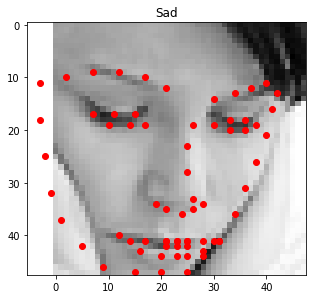

In [42]:
visualizeFaceVector(42)

In [162]:
from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers.experimental.preprocessing import Normalization
from tensorflow.keras.optimizers import Adam, RMSprop, SGD

In [188]:
x_train, x_test, y_train, y_test = train_test_split(df['vector'],
                                                    df['emotion'],
                                                    test_size=0.2,
                                                    stratify=df['emotion'],
                                                    random_state=42)

x_train.shape, x_test.shape, y_train.shape, y_test.shape

((28709,), (7178,), (28709,), (7178,))

In [189]:
# transform lists of vector values into numpy arrays
x_train = np.vstack(x_train)
x_test = np.vstack(x_test)

# Convert the pandas series of target classes to numpy array
y_train = np.asarray(y_train)
y_test = np.asarray(y_test)

x_train.shape, y_train.shape

((28709, 136), (28709,))

In [211]:
model = Sequential([Input(shape=x_train.shape[1:]),
                    Normalization(),
                    Dense(128, activation='relu'),
                    Dense(128, activation='relu'),
                    Dense(64, activation='relu'),
                    Dense(64, activation='relu'),
                    Dense(32, activation='relu'),
                    Dense(32, activation='relu'),
                    Dense(7, activation='softmax')])

model.compile(optimizer=Adam(lr=.001), loss='sparse_categorical_crossentropy', metrics=['acc'])
model.summary()

Model: "sequential_30"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_18 (Normalizat (None, 136)               273       
_________________________________________________________________
dense_146 (Dense)            (None, 128)               17536     
_________________________________________________________________
dense_147 (Dense)            (None, 128)               16512     
_________________________________________________________________
dense_148 (Dense)            (None, 64)                8256      
_________________________________________________________________
dense_149 (Dense)            (None, 64)                4160      
_________________________________________________________________
dense_150 (Dense)            (None, 32)                2080      
_________________________________________________________________
dense_151 (Dense)            (None, 32)              

In [212]:
stop = EarlyStopping(monitor='val_acc', patience=5, restore_best_weights=True)

history = model.fit(x_train, 
          y_train,
          validation_data=(x_test, y_test),
          epochs=100, 
          batch_size=128, 
          callbacks=[stop])

Epoch 1/100
225/225 [==============================] - 1s 4ms/step - loss: 1.9192 - acc: 0.2589 - val_loss: 1.7084 - val_acc: 0.2991
Epoch 2/100
225/225 [==============================] - 1s 3ms/step - loss: 1.6729 - acc: 0.3397 - val_loss: 1.8233 - val_acc: 0.2346
Epoch 3/100
225/225 [==============================] - 1s 3ms/step - loss: 1.6322 - acc: 0.3599 - val_loss: 1.7053 - val_acc: 0.3272
Epoch 4/100
225/225 [==============================] - 1s 3ms/step - loss: 1.5877 - acc: 0.3830 - val_loss: 1.5860 - val_acc: 0.3771
Epoch 5/100
225/225 [==============================] - 1s 3ms/step - loss: 1.5658 - acc: 0.3918 - val_loss: 1.5697 - val_acc: 0.3911
Epoch 6/100
225/225 [==============================] - 1s 3ms/step - loss: 1.5477 - acc: 0.3981 - val_loss: 1.6194 - val_acc: 0.3710
Epoch 7/100
225/225 [==============================] - 1s 3ms/step - loss: 1.5325 - acc: 0.4058 - val_loss: 1.5124 - val_acc: 0.4136
Epoch 8/100
225/225 [==============================] - 1s 3ms/step - 

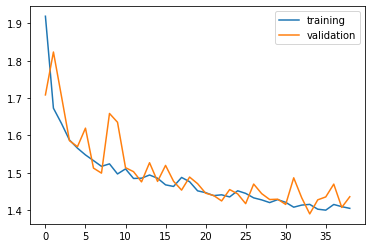

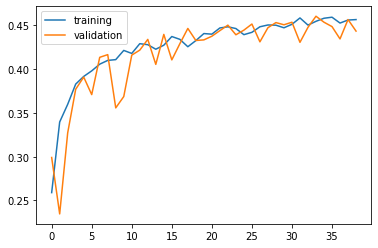

In [213]:
plt.plot(history.history['loss'], label='training')
plt.plot(history.history['val_loss'], label='validation')
plt.legend()
plt.show()

plt.plot(history.history['acc'], label='training')
plt.plot(history.history['val_acc'], label='validation')
plt.legend()
plt.show()

In [214]:
score = model.evaluate(x_test, y_test)[1]
print(f'Accuracy on test {round(score * 100, 2)} %')

225/225 [==============================] - 0s 1ms/step - loss: 1.3897 - acc: 0.4606
Accuracy on test 46.06 %


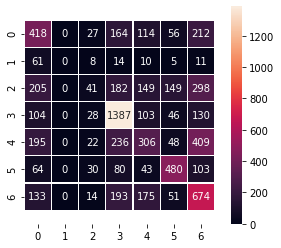

In [215]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

preds = model.predict(x_test)
y_pred = [np.argmax(pred) for pred in preds]
cm = confusion_matrix(y_test, y_pred)

ax = sns.heatmap(cm, annot=True, fmt='d', linewidths=.2, square=True)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5);

In [153]:
classes

['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']